In [4]:
from django.shortcuts import render
from django.views.decorators.csrf import csrf_exempt
from django.shortcuts import HttpResponse

import argparse
import json
import numpy as np
import requests
import cv2

from PIL import Image
from PIL.ExifTags import TAGS
from keras.preprocessing import image

from io import BytesIO
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

#plt.rcParamas['axes.labelsize'] = 18
#plt.rcParams['xtick.labelsize'] = 16
#plt.rcParams['ytick.labelsize'] = 16

#matplotlib 한글 폰트 설정

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = fm.FontProperties(fname=path, size=16).get_name()
print(font_name)
plt.rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False
fm._rebuild()

NanumGothic Eco


In [10]:
img_path = os.path.join('imgfiles','na.jpg')

In [11]:
img = cv2.imread(img_path)
img.shape

(3024, 4032, 3)

In [12]:
img.shape

(3024, 4032, 3)

In [13]:
input_seglink = cv2.resize(img, (512,512), cv2.INTER_AREA)

In [14]:
input_t = input_seglink.astype('int32')

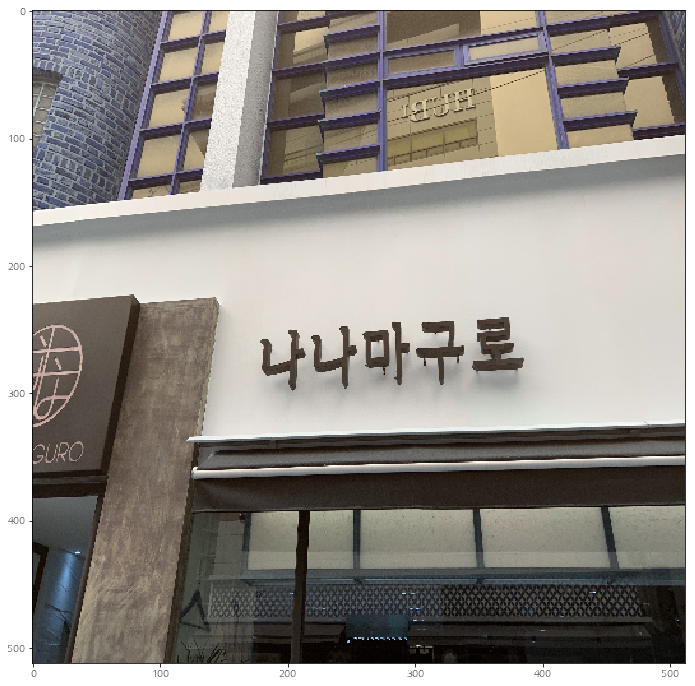

In [17]:
plt.figure(figsize=(12,12))
plt.imshow(input_t)

In [21]:
payload_seglink = {
        "instances": [{'input_1:0': input_seglink.tolist()}]
    } 

res_seglink = requests.post('http://222.236.33.249:9002/v1/models/seglink:predict', json=payload_seglink)

pred_seglink = json.loads(res_seglink.content.decode('utf-8'))
pred_seglink_np = np.array(pred_seglink['predictions']) # (1, 5461, 31)
pred_seglink_np = np.squeeze(pred_seglink_np, axis=0) # (5461, 31)

In [22]:
import sys
import os
sys.path.append(os.path.dirname("../../webserver/abs"))
from tfserving.utils import sl_util, crop_word
from tfserving.utils.crnn_utils import decode
from tfserving.utils.crnn_utils import dict838 as dic
from tfserving.utils.bboxes import rbox_to_polygon
prior_util = sl_util.PriorUtil()

In [23]:
segment_threshold = 0.4
link_threshold = 0.35

boxes = prior_util.decode(pred_seglink_np, segment_threshold, link_threshold, debug=False)

## 박스 크기 조정

In [25]:
rboxes = boxes[:,:5]

bh = rboxes[:,3]
rboxes[:,2] += bh * 0.1 #width
rboxes[:,3] += bh * 0.05 #heigh

xylist = []
xy_raw = []
for box in range(len(rboxes)):
    xy_rec = rbox_to_polygon(rboxes[box])    
    xy_rec = np.flip(xy_rec, axis = 0)
    xy_raw.append(xy_rec)
    xy_r = [r/512 for r in xy_rec]
    xylist.append(xy_r)
    
print(len(xylist),"개 박스 발견")

8 개 박스 발견


## 박스 원본 크기 

In [24]:
xylist = []
xy_raw = []
for box in range(len(boxes)):
    xy_rec = rbox_to_polygon(boxes[box][:5])    
    xy_rec = np.flip(xy_rec, axis = 0)
    xy_raw.append(xy_rec)
    xy_r = [r/512 for r in xy_rec]
    xylist.append(xy_r)
    
print(len(xylist),"개 박스 발견")

4 개 박스 발견


In [31]:
words, vac = crop_word.crop_words(input_seglink, xylist, grayscale=True)

xy_raw = np.delete(xy_raw, vac,0)
    
word_images = np.ones([len(words), 256, 32, 1])

for j in range(len(words)):
    word_images[j] = words[j].transpose(1,0,2)

['구0', '0', '나나파구로', '전림의']


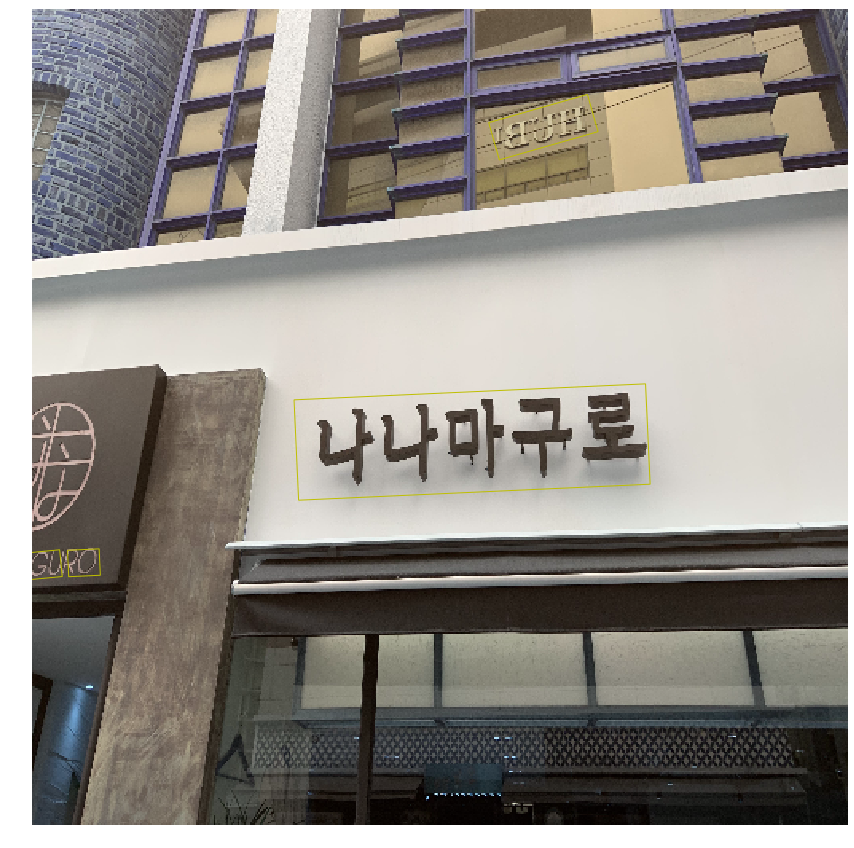

In [38]:
text_list = []
for input_crnn in word_images:

    payload_crnn = {
        "instances": [{'image_input:0' : input_crnn.tolist()}]
    }

    res_crnn = requests.post('http://222.236.33.249:9002/v1/models/crnn:predict', json=payload_crnn)

    pred_crnn = json.loads(res_crnn.content.decode('utf-8'))
    pred_crnn_np = np.array(pred_crnn['predictions']) # (1, 62, 836)
    pred_crnn_np = np.squeeze(pred_crnn_np, axis=0) # (62, 836)

    chars = [dic[c] for c in np.argmax(pred_crnn_np,axis=1)]
    res_str = decode(chars) # final text

    text_list.append(res_str)

print(text_list)
plt.figure(figsize=(15,15))
ax = plt.gca()
im = plt.gci()
plt.imshow(input_seglink)
for t in range(len(text_list)):
    ax.add_patch(plt.Polygon(xy_raw[t], fill=False, edgecolor='y', linewidth=1))
    ax.text(xy_raw[t][0][0], xy_raw[t][0][1], text_list[t], bbox={'facecolor':'y', 'alpha':0.5}, rotation=0)

plt.axis('off')
plt.show()